In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

from sqlalchemy import create_engine

In [ ]:
# 데이터 병합 및 year 열 추가 함수 정의의: SQL
def get_data_from_db(query):

    # mysql 접속 정보 정의
    username = "admin"
    password = "admin1234"
    host = "hk-toss-middle-project.cjkcuqkegqpx.eu-north-1.rds.amazonaws.com"
    database_name = "raw_data"

    # 데이터베이스 연결 문자열, connection string
    db_connection_str = f'mysql+pymysql://{username}:{password}@{host}/{database_name}'

    # 데이터 베이스 connector 얻어내기
    db_connection = create_engine(db_connection_str)
    db_connection

    df = pd.read_sql(query, con=db_connection)
    return df

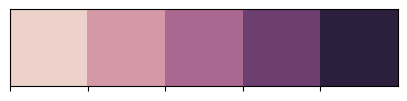

In [ ]:
# 시각화 팔레트 설정
default_cube = sns.cubehelix_palette(5)
palette = sns.color_palette(default_cube)
sns.palplot(palette)
sns.set_palette(default_cube)



# 보장 유형

In [ ]:
# 3개년 데이터 병합 후 PHI_TYPE, D_YEAR만 불러오기
query = f"""
SELECT 
    D_YEAR,
    PHI_TYPE, 
    SUM(CNT) AS TOTAL_CNT
FROM (
    SELECT 
        2019 AS D_YEAR, 
        PHI4 AS PHI_TYPE, 
        COUNT(PHI4) AS CNT
    FROM 
        raw_a_phi
    GROUP BY 
        PHI4

    UNION ALL

    SELECT 
        2020 AS D_YEAR, 
        PHI4 AS PHI_TYPE, 
        COUNT(PHI4) AS CNT
    FROM 
        raw_b_phi
    GROUP BY 
        PHI4

    UNION ALL

    SELECT 
        2021 AS D_YEAR, 
        PHI4 AS PHI_TYPE, 
        COUNT(PHI4) AS CNT
    FROM 
        raw_c_phi
    GROUP BY 
        PHI4
) AS subquery
GROUP BY 
    D_YEAR,
    PHI_TYPE
ORDER BY TOTAL_CNT DESC;"""
phi_type = get_data_from_db(query)
phi_type.head()

,D_YEAR,PHI_TYPE,TOTAL_CNT
0,2021,"1,2,3",4879.0
1,2020,"1,2,3",4705.0
2,2019,"1,2,3",4433.0
3,2020,2,3345.0
4,2021,2,3314.0


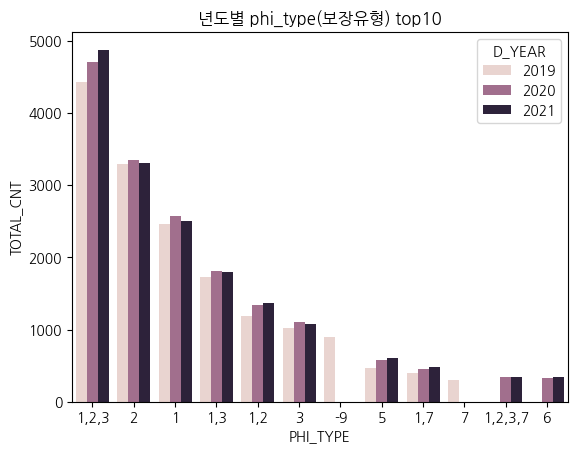

In [ ]:
# 시각화

# 년도 별 top10
# 년도 별 top 10 뽑아보기
phi_type_year_sort = phi_type.sort_values(by=["D_YEAR","TOTAL_CNT"], ascending=[True, False]).groupby("D_YEAR").head(10)

# bar chart
import seaborn as sns

sns.barplot(
    data = phi_type_year_sort,
    x = "PHI_TYPE",
    y = "TOTAL_CNT",
    hue="D_YEAR"
)
plt.title("년도별 phi_type(보장유형) top10")
plt.tight_layout
plt.show()

# 월 납입 보험료

In [ ]:
query = f"""
SELECT PHI6 AS PREMIUM, 2019 AS D_YEAR
FROM raw_a_phi
WHERE PHI6 != -9
UNION ALL
SELECT PHI6 AS PREMIUM, 2020 AS D_YEAR
FROM raw_b_phi
WHERE PHI6 != -9
UNION ALL
SELECT PHI6 AS PREMIUM, 2021 AS D_YEAR
FROM raw_c_phi
WHERE PHI6 != -9
"""
phi_premium = get_data_from_db(query)
phi_premium.head()

,PREMIUM,D_YEAR
0,120000.0,2019
1,118000.0,2019
2,48710.0,2019
3,62800.0,2019
4,201717.0,2019


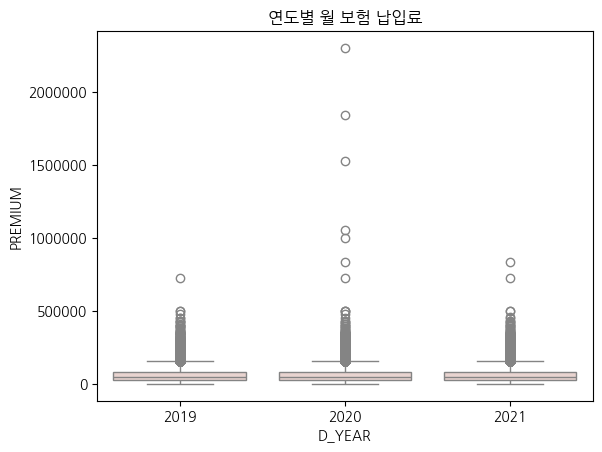

In [ ]:
# boxplot
sns.boxplot(
    data = phi_premium,
    x = "D_YEAR",
    y = "PREMIUM",
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')

plt.title("연도별 월 보험 납입료")
plt.show()


# 보험금 청구 여부

In [ ]:
query = f"""
SELECT D_YEAR, CLAIM, SUM(CNT) as COUNT
FROM(
SELECT 2019 AS D_YEAR, PHR1 AS CLAIM, COUNT(PHR1) AS CNT
FROM raw_a_phi
GROUP BY PHR1
UNION ALL
SELECT 2020 AS D_YEAR, PHR1 AS CLAIM, COUNT(PHR1) AS CNT
FROM raw_b_phi
GROUP BY PHR1
UNION ALL
SELECT 2021 AS D_YEAR, PHR1 AS CLAIM, COUNT(PHR1) AS CNT
FROM raw_c_phi
GROUP BY PHR1
) AS subquery
GROUP BY D_YEAR, CLAIM
"""
phi_claim = get_data_from_db(query)
phi_claim

,D_YEAR,CLAIM,COUNT
0,2019,1.0,1278.0
1,2019,2.0,19910.0
2,2019,-9.0,350.0
3,2020,2.0,19360.0
4,2020,1.0,1899.0
5,2020,-9.0,86.0
6,2021,2.0,19410.0
7,2021,1.0,1956.0
8,2021,-9.0,26.0


In [ ]:
# 범주 값 변경
phi_claim.loc[phi_claim["CLAIM"]==-9, "CLAIM"] = "모름/무응답"
phi_claim.loc[phi_claim["CLAIM"]==1, "CLAIM"] = "예"
phi_claim.loc[phi_claim["CLAIM"]==2, "CLAIM"] = "아니오"

C:\Users\user\AppData\Local\Temp\ipykernel_18708\13018775.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '모름/무응답' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  phi_claim.loc[phi_claim["CLAIM"]==-9, "CLAIM"] = "모름/무응답"


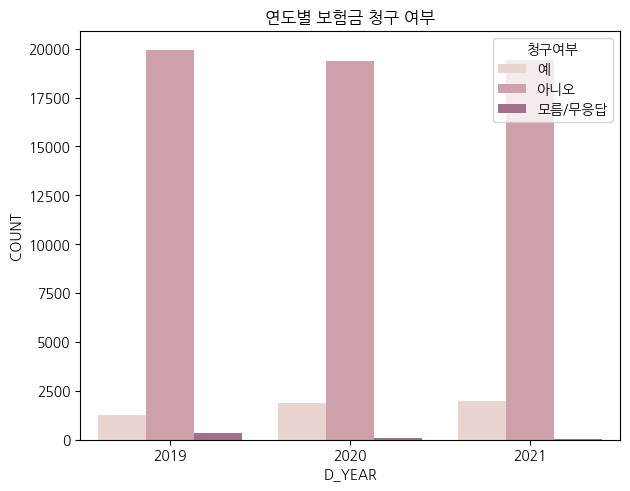

In [ ]:
# barplot
sns.barplot(
    data = phi_claim,
    x = "D_YEAR",
    y = "COUNT",
    hue = "CLAIM"
)
plt.tight_layout()
plt.legend(title="청구여부")
plt.title("연도별 보험금 청구 여부")
plt.show()

# 보험금 수령액

In [ ]:
query = f"""
SELECT PHR3 AS BENEFIT, 2019 AS D_YEAR
FROM raw_a_phi
WHERE PHR3 is not null AND PHR3 != -9
UNION ALL
SELECT PHR3 AS BENEFIT, 2020 AS D_YEAR
FROM raw_b_phi
WHERE PHR3 is not null AND PHR3 != -9
UNION ALL
SELECT PHR3 AS BENEFIT, 2021 AS D_YEAR
FROM raw_c_phi
WHERE PHR3 is not null AND PHR3 != -9
"""
phi_benefit = get_data_from_db(query)

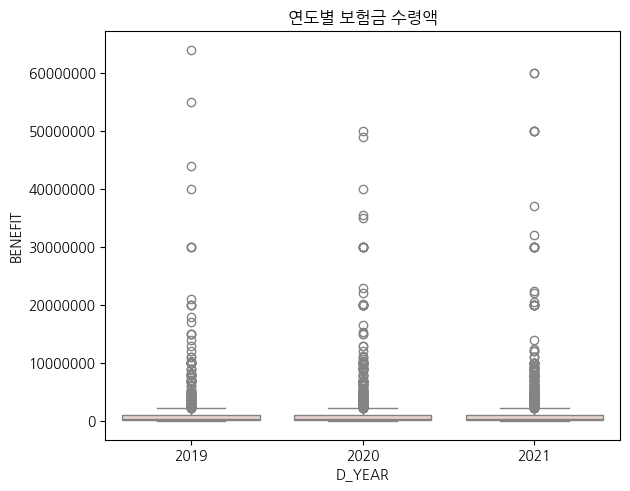

In [ ]:
# boxplot
sns.boxplot(
    data = phi_benefit,
    x = "D_YEAR",
    y = "BENEFIT"
)
# y축 tick label을 실수 형식으로 변경
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.title("연도별 보험금 수령액")
plt.show()

# 보험금 수령 여부 별 월 보험료

In [ ]:
query = f"""
SELECT PHI6 AS PREMIUM, 2019 AS D_YEAR, PHR2 AS BENEFIT_YN
FROM raw_a_phi
WHERE PHI6 != -9 AND PHI6 is not null AND PHR2 is not null 
UNION ALL
SELECT PHI6 AS PREMIUM, 2020 AS D_YEAR, PHR2 AS BENEFIT_YN
FROM raw_b_phi
WHERE PHI6 != -9 AND PHI6 is not null AND PHR2 is not null 
UNION ALL
SELECT PHI6 AS PREMIUM, 2021 AS D_YEAR, PHR2 AS BENEFIT_YN
FROM raw_c_phi
WHERE PHI6 != -9 AND PHI6 is not null AND PHR2 is not null
"""
phi_benefit_yn_premium = get_data_from_db(query)

In [ ]:
phi_benefit_yn_premium

,PREMIUM,D_YEAR,BENEFIT_YN
0,120000.0,2019,1.0
1,87000.0,2019,1.0
2,60770.0,2019,1.0
3,75000.0,2019,1.0
4,150000.0,2019,2.0
...,...,...,...
4922,121260.0,2021,1.0
4923,144168.0,2021,1.0
4924,39000.0,2021,1.0
4925,109058.0,2021,1.0


In [ ]:
phi_benefit_yn_premium.groupby("BENEFIT_YN")["PREMIUM"].mean()

BENEFIT_YN
1.0    74459.237659
2.0    66934.907407
3.0    70411.888889
Name: PREMIUM, dtype: float64

In [ ]:
# 범주 값 변경
phi_benefit_yn_premium.loc[phi_benefit_yn_premium["BENEFIT_YN"]==1, "BENEFIT_YN"] = "예"
phi_benefit_yn_premium.loc[phi_benefit_yn_premium["BENEFIT_YN"]==2, "BENEFIT_YN"] = "아니오"
phi_benefit_yn_premium.loc[phi_benefit_yn_premium["BENEFIT_YN"]==3, "BENEFIT_YN"] = "청구진행중"

C:\Users\user\AppData\Local\Temp\ipykernel_18708\135648012.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '예' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  phi_benefit_yn_premium.loc[phi_benefit_yn_premium["BENEFIT_YN"]==1, "BENEFIT_YN"] = "예"


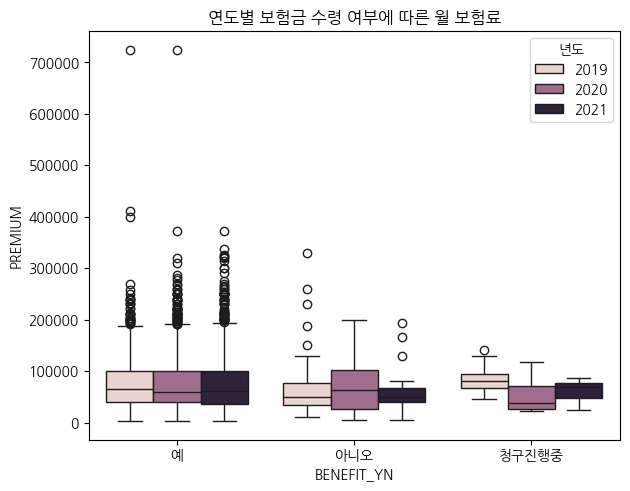

In [ ]:
# boxplot
sns.boxplot(
    data = phi_benefit_yn_premium,
    x = "BENEFIT_YN",
    y = "PREMIUM",
    hue = "D_YEAR"
)
plt.tight_layout()
plt.legend(title="년도")
plt.title("연도별 보험금 수령 여부에 따른 월 보험료")
plt.show()
